# From Linear to Deep Classifiers

<img align="right" src="https://github.com/seismotologist/seismoDL101/blob/master/code/figs/Voosen_2018_Science_Fig.png?raw=1" width="540">

In this tutorial we design, train & compare 4 different supervised machine learning classifiers with different degrees of complexity, to distinguish seismic P-wave seismograms from impulsive noise signals:

- Model 1: linear classifier
- Model 2: simple fully connected neural network
- Model 3: tiny convolutional neural network
- Model 4: deeper convolutional neural network

The exercise demonstrates to what extent deeper models can outperform shallower ones - if we have enough training data. We will also ask the question just how much data is necessary to effectively train a deep classifier. By Men-Andrin Meier, February 15, 2019, mmeier@caltech.edu

<div style="min-height:100px">

##### Motivation

Imagine you run an Earthquake Early Warning (EEW) system, and you want to send out real-time seismic alerts whenever you detect that an earthquake is occuring. Because the seismic waves travel fast (~3km/s for S-waves) EEW is a race against time. If the alerts are to be useful you need to send them out very rapidly. Otherwise the target sites will have been hit by the seismic waves before they received the alert. You only have a few seconds to decide whether an observed seismic signal is from a real earthquake or a nuisance signal, e.g. from a nearby truck, or from a cow kicking one of your seismometers... This decision can be difficult because nuisance signals can initially look a lot like earthquake signals. Standard linear classifiers are barely accurate enough for this difficult task, and may cause false and missed alerts. In this tutorial we'll see that with deep learning we can design classifiers that can discriminate between the two signal types almost without errors. (Figure from __[Voosen, 2018, Science](http://science.sciencemag.org/content/362/6414/514/tab-pdf)__)

##### Overview
1. The Waveform Onset Data Set
2. Four Classifier Models
3. Performance Comparison Between Models
4. Just how much data do you need...?
5. Take Home Messages



_Acknowledgements_: Cheers to Oliver Stephenson and the MESS 2019 participants for constructive comments that helped improve the tutorial.

In [0]:
import numpy as np
import pylab as plt
import warnings
import os
import h5py
import matplotlib as mpl
%matplotlib inline

import sklearn
from sklearn import linear_model

import pandas as pd
import seaborn as sns

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras import losses
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
import keras.backend as K

Using TensorFlow backend.


In [0]:
!wget https://github.com/seismotologist/seismoDL101/blob/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5?raw=true -O onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5
!wget https://github.com/seismotologist/seismoDL101/blob/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Val_nrec10000.h5?raw=true -O onsetWforms_allM3p_180618_rpkd_QN_naug1_Val_nrec10000.h5

--2019-09-03 05:58:03--  https://github.com/seismotologist/seismoDL101/blob/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/seismotologist/seismoDL101/raw/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5 [following]
--2019-09-03 05:58:03--  https://github.com/seismotologist/seismoDL101/raw/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/seismotologist/seismoDL101/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5 [following]
--2019-09-03 05:58:03--  https://raw.githubusercontent.com/seismotologist/seismoDL101/master/data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_

## 1 The Waveform Onset Data Set
We will be using a subset of the data set of __[Meier et al., 2019, JGR](https://arxiv.org/abs/1901.03467)__. The data set contains 10,000 short three component seismograms from two signal classes: real earthquake P-waves ("quake") and impulsive noise signals that are not caused by earthquakes  ("noise"). For each record we have the waveforms ('W'), a set of 25 scalar features derived from the waveforms, such as peak amplitudes in different frequency bands ('F'), and class labels ('Y', 1 for quake, 0 for noise). 

##### Training, validation and testing data
We have already split the data set into 8,000 training and 2,000 testing records. During the training process, we will set aside part of the training data as _validation data_, to estimate the out-of-sample prediction error while we optimize the model. Once we have identified a best model, we can then evaluate it on the 2,000 _testing data_ records which were not used anywhere during the training process. For more details on data splits see e.g. __[The Elements of statistical learning](https://web.stanford.edu/~hastie/ElemStatLearn/)__, p. 222.

In [0]:
# Files
train_file = "onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5"
val_file   = "onsetWforms_allM3p_180618_rpkd_QN_naug1_Val_nrec10000.h5"

ftrain   = h5py.File(train_file,'r')
W_train  = ftrain['/X'][()]        # waveforms
F_train0 = ftrain['/F'][()]        # scalar features
Y_train  = ftrain['/Y'][()]        # labels
ntr      = F_train0.shape[0]

fval    = h5py.File(val_file,'r')
W_test  = fval['/X'][()]
F_test0 = fval['/F'][()]
Y_test  = fval['/Y'][()]
nte     = F_test0.shape[0]

print("Number of training records: "+str(ntr))
print("Number of testing  records: "+str(nte))

Number of training records: 8000
Number of testing  records: 2000


### Data visualisation
Let's start by visualizing some of the data set so that we know what we are dealing with. 

##### Waveforms
We start by plotting a few randomly chosen example waveforms from the two signal classes. For most of the quake waveforms we can see a distinct signal onset at 50-150 samples. For the noise waveforms this is usually not the case. But with such short signal durations, it can be difficult to discriminate the two signal classes, even for a human expert seismologist. This shows how difficult this discrimination is in an EEW context. You can execute this cell multiple times to see more signal examples.

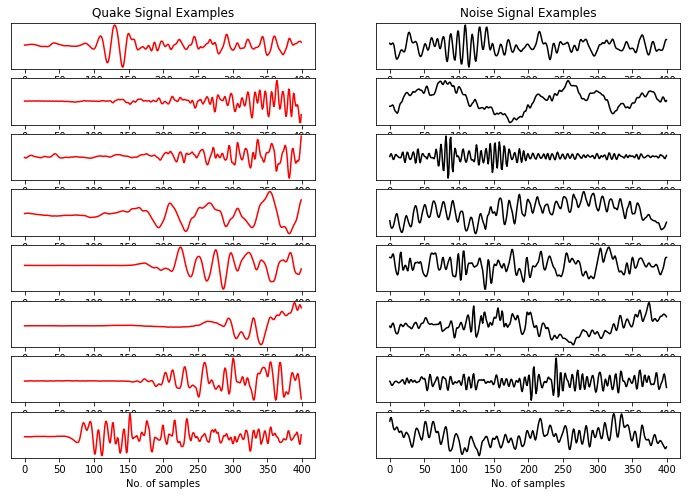

In [0]:
# Waveform data parameters
nplot = 8       # For either class plot <nplot> examples
nwin  = 400     # No. of samples per record
ncomp = 3       # No. of record components (Z,E,N)

# Select random quake examples
idxQ  = np.where(Y_test==1)
idxQ  = idxQ[0]
irndQ = np.random.randint(1,len(idxQ),nplot)
iQ    = idxQ[irndQ]
#print(Y_test[iQ])

# Select random quake examples
idxN  = np.where(Y_test==0)
idxN  = idxN[0]
irndN = np.random.randint(1,len(idxN),nplot)
iN    = idxN[irndN]
#print(Y_test[iN])

fig, axes = plt.subplots(nplot,2);
fig.set_size_inches(12,8);

for iplot in range(1,nplot+1):

    wQ = W_test[iQ[iplot-1],:,1]
    ax = axes[iplot-1,0]
    ax.plot(wQ,color='r')
    ax.yaxis.set_ticks([])
    
    wN = W_test[iN[iplot-1],:,1]
    ax = axes[iplot-1,1]
    ax.plot(wN,color='k')
    ax.yaxis.set_ticks([])

axes[0,0].title.set_text('Quake Signal Examples')
axes[0,1].title.set_text('Noise Signal Examples')
axes[-1,0].set_xlabel('No. of samples')
axes[-1,1].set_xlabel('No. of samples');

##### Scalar feature data
The scalar features contain waveform-derived quantities, such as zero-crossing-rates and peak absolute amplitudes in different frequency bands. They have been measured on each signals with various signal durations. Below we will choose isnp=3 which will extract the features measured over the first 3s since the signal onset. 

Here we use only a subset of features to analyse, because a lot of the features may be correlated and may not contain independent information. We use peak amplitudes in 7 frequency passbands from 0.2-24Hz (features no. 18-25 in F_train0 and F_test0). Rigorous __[dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)__ is an important & interesting topic in itself, but here we just select a sub-set of features for simplicity.

In [0]:
# Feature data: subselect features to use
nf = F_train0.shape[1]   # total number of different features

#iuse = range(0,nf)     # all
#iuse = range(2,5)      # peak absolute acc., vel., dsp.
iuse = range(18,nf)     # filter bank amplitudes
isnp = 3                 

F_train  = F_train0[:,iuse,isnp]
F_test   = F_test0[:,iuse,isnp]
nf       = F_train.shape[1]

print("Training feature matrix shape: "+str(F_train.shape))
print("Testing  feature matrix shape: "+str(F_test.shape))

Training feature matrix shape: (8000, 7)
Testing  feature matrix shape: (2000, 7)


After we write the feature data into a _pandas_ dataframe we can use _seaborn_ to easily plot pairs of features against each other. If the features of two classes were linearly separable, a linear classifier would be enough to discriminate between the quake and noise signals with high accuracy. We see, however, that there is a lot of overlap between the two classes for all feature pairs:

2000


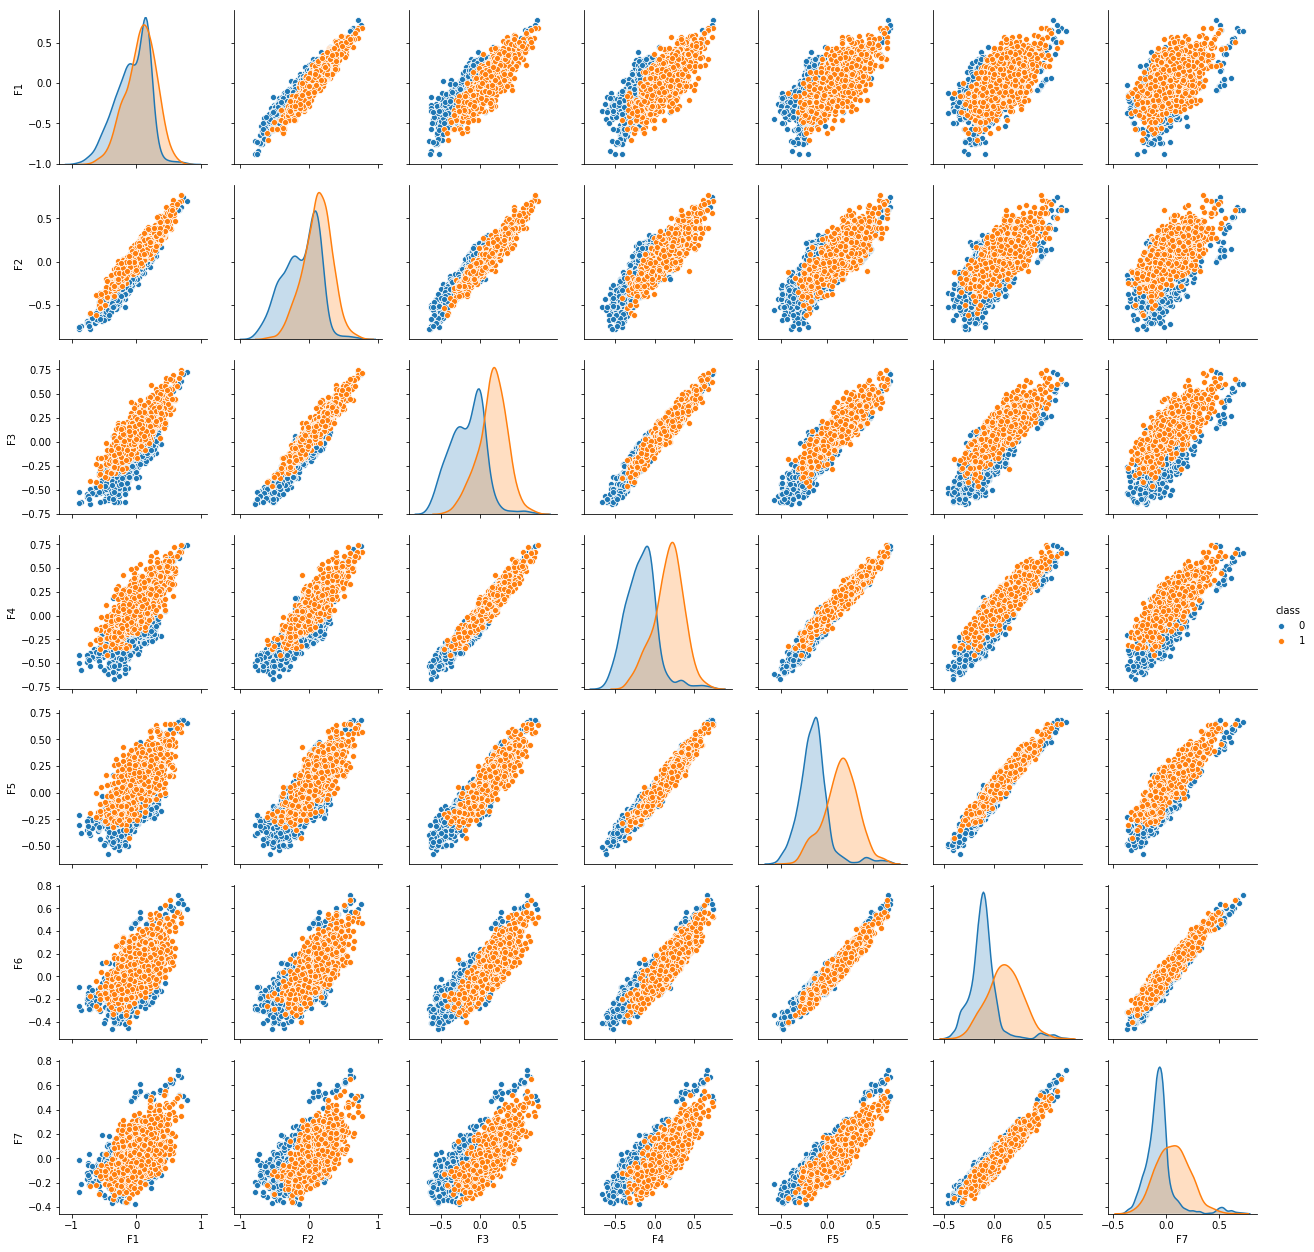

In [0]:
# Write features into pandas data frame
F = F_test.transpose();             
d = {'F1': F[0,:], 'F2': F[1,:], 'F3': F[2,:],'F4': F[3,:],
     'F5': F[4,:], 'F6': F[5,:], 'F7': F[6,:],'class': Y_test}
df = pd.DataFrame(data=d)
print(len(df))

sns.pairplot(df, vars=["F1","F2","F3","F4","F5","F6","F7"], hue='class')
plt.show()

## 2 Four Classifier Models

Now let's train some classifiers that predict which signals belong to the _quake_ class, and which ones belong to the _noise_ class.

### Model 1: A Standard Linear Classifier
As a starting model we use the scalar feature data to fit a standard linear classifier from scikit-learn. The classifier reaches classification accuracies of close to 90%.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier as gb
#model1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
model1 = gb()
model1.fit(F_train,Y_train)

train_accurcay = model1.score(F_train,Y_train)
test_accurcay  = model1.score(F_test,Y_test)
print('Accuracy on training data: '+str(train_accurcay)+'%')
print('Accuracy on testing  data: '+str(test_accurcay)+'%')

Accuracy on training data: 0.927%
Accuracy on testing  data: 0.915%


Note: the feature pairplot shows that the peak amplitude features we use are quite strongly correlated with each other, i.e. they are not independent. Other feature combinations may form a better basis for the classification exercise. You can vary the feature selection to see if you can increase the accuracy of the linear classifier.

### Model 2: A Small Fully Connected Neural Network
Let's see if we can improve on the linear classifier by using a fully connected neural network (FCNN) classifier. We use the same peak amplitude feaures as input. 

FCNNs are networks of neurons, which are organized in layers. Each individual neuron performs a simple operation: it computes a weighted average of the outputs from all neurons of the previous layer and then applies a non-linear ‘activation function’ $\varphi$, e.g. a sigmoid: $\varphi(x) = 1/(1+exp(-x)))$. The output of this operation is passed on to the neurons in the next layer. The weights $w_i$ are the free parameters that are optimised during the training. Together, this network of simple operations constitutes a complex and highly flexible mapping function between input (e.g. our 7 feature values) and output (e.g. the probability that the target record is a quake signal). 

<img align="center" src="https://github.com/seismotologist/seismoDL101/blob/master/code/figs/fcnn_sketch_2.png?raw=1" width="700">

We can then use the training data to empirically optimise the weights $w_i$ of all neurons, such that the output is as close as possible to what we want it to be. Here, we use a single neuron at the output layer, which will give us the _quake_ probability, i.e. the probability that the input features came from a signal of the quake class. We want to find a set of weights that result in a _quake_ probability close to 1 if we input the feature values from a quake record, and a _quake_ probability close to 0 if we input feature values from a noise record.


Because of the activation functions, the mapping function is inherently non-linear. For more details on FCNNs, take some time to study a text book or some of the many excellent online resources, e.g., __[this blog by Towards Data Science](https://towardsdatascience.com/under-the-hood-of-neural-networks-part-1-fully-connected-5223b7f78528)__.

###### Model design
In keras, building a neural network classifier is easy... you can just stack different layers on top of one another, as shown in the following example. You can play with the number of nodes per layer and see how the number of free parameters in the model changes. We can also select different activation functions for different layers. We use 'dropout' as a form of _model regularisation_. That is, we randomly leave out a certain fraction of connections between neurons (here, 20%). This reduces the model complexity and prevents overfitting, as explained by __[Srivastava and colleagues](http://jmlr.org/papers/v15/srivastava14a.html)__.

In [0]:
model2 = Sequential()
model2.add(Dense(36, input_dim=nf, activation='relu'))  # fully connected layer
model2.add(Dropout(0.2))                                # set n% of weights to zero as a means
                                                        # of regularization
model2.add(Dense(36, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid'))

print(model2.summary())

W0903 05:58:27.437169 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 05:58:27.509783 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 05:58:27.523591 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 05:58:27.554255 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0903 05:58:27.569587 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36)                288       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 36)                1332      
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 37        
Total params: 1,657
Trainable params: 1,657
Non-trainable params: 0
_________________________________________________________________
None


###### Model Optimisation / Training
Now that we've designed the model, the next step is the parameter optimisation, or, _training_. For this we can specify a _loss function_ that measures the model performance. In our binary classification problem the loss quanitifies the discrepancy between the predicted and the true labels ('quake' vs 'noise'). Low loss implies that the model predicted most of the record classes correctly.

How do we find the optimal set of weights that leads to the best performance, or lowest loss? Most supervised machine learning models use some variant of _stochastic gradient descent (SGD)_ to iteratively find increasingly better weights, i.e. weights that lead to increasingly low loss values. At each iteration the method computes the partial derivatives of the loss function with respect to all weights, and then updates the weights along the negative gradient, i.e. such that the strongest loss reduction is achieved. This is repeated until a, hopefully global, minimum of the loss function is found. Here we use the commonly used _Adam optimizer_ of __[Kingma and Ba, 2014](https://arxiv.org/abs/1412.6980)__, which is a form of SGD that uses adaptive learning rates.

We can specify the desired loss function and the optimisation algorithm when we compile the keras model, along with the performance metrics we want to keep track of (here, classification accuracy). For more details see the __[keras documentation](https://keras.io/)__.

In [0]:
model2.compile(loss='binary_crossentropy', # 'categorical_hinge', ...
               optimizer='adam',           # 'rmsprop', 'adagrad', ...
               metrics=['accuracy'])       

W0903 05:58:27.648930 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0903 05:58:27.680526 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0903 05:58:27.689111 140031527532416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We now use the training data to optimise the model performance. Instead of processing the entire data set before each parameter update, we use so called _mini batches_, which are small subsets of the total data set. For each mini batch we compute the gradient of the loss function and then update the parameters in the direction of the strongest negative gradient. After setting aside 20% validation data we have 6,400 records for training. With a batch size of 128, this gives 50 batches. A run through all batches is called an _epoch_.  

Optimizing the parameters with mini batches allows us to update parameters faster and more efficiently than if the entire data set had to be processed for each parameter update. Furthermore, it will also allow us to do *batch normalization*, which is a form of model regularization (see Model 3). 

In [0]:
history2 = model2.fit(F_train, Y_train,
                      validation_split=0.2,  # set aside data for model selection
                      epochs=15,             # maximum number of iterations
                      batch_size=128,        # optimise parameters only over small batches
                      verbose = 1)

Train on 6400 samples, validate on 1600 samples
Epoch 1/15
6400/6400 [==============================] - 5s 761us/step - loss: 0.6387 - acc: 0.7623 - val_loss: 0.5675 - val_acc: 0.8325
Epoch 2/15
6400/6400 [==============================] - 0s 44us/step - loss: 0.4975 - acc: 0.8323 - val_loss: 0.4294 - val_acc: 0.8469
Epoch 3/15
6400/6400 [==============================] - 0s 43us/step - loss: 0.3980 - acc: 0.8564 - val_loss: 0.3715 - val_acc: 0.8575
Epoch 4/15
6400/6400 [==============================] - 0s 44us/step - loss: 0.3556 - acc: 0.8692 - val_loss: 0.3315 - val_acc: 0.8769
Epoch 5/15
6400/6400 [==============================] - 0s 41us/step - loss: 0.3260 - acc: 0.8811 - val_loss: 0.3047 - val_acc: 0.8838
Epoch 6/15
6400/6400 [==============================] - 0s 41us/step - loss: 0.3103 - acc: 0.8786 - val_loss: 0.2838 - val_acc: 0.8962
Epoch 7/15
6400/6400 [==============================] - 0s 44us/step - loss: 0.2988 - acc: 0.8864 - val_loss: 0.2735 - val_acc: 0.8950
Epoch 

After training, we can plot the evolution of the classification accuracy and of the loss function across the training epochs:

In [0]:
def plot_training_history(history):
    #print(history.history.keys())

    fig = plt.figure()
    fig.set_size_inches(10,5);
    
    ax1=plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    #plt.show()

    ax2=plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

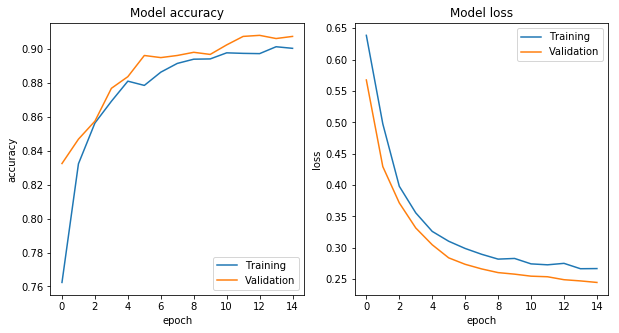

In [0]:
# Plot model evolution during training process
plot_training_history(history2)

### Convolutional Neural Network Classifiers
Convolutional neural networks (CNNs) are a powerful and intuitive extension of FCNNs. Standard CNNs combine a fully connected network with a convolutional _feature extraction system_. This allows them to work on the raw input data directly (e.g. bitmap images time series data), instead of derived features. 

In each convolutional layer, the layer inputs are convolved with a series of parallel digital filters ('channels'), each of which is parameterized with a small number of scalar filter coefficients. During the training process, the filter coefficients themselves are optimized (that is, *learned*). This way the network learns directly from the data which aspects are important for the task the network is designed to do. In our example, the network will learn to extract the features that are diagnostic of whether the input is a quake or a noise signal. This frees us from the difficult task of choosing/engineering the right features manually, which is a key advantage of deep learning models. We just input the seismogram directly.

Note that the network shown below has three output nodes, which give the class probabilities for each of three possible classes (from __[Ross et al., 2018](https://arxiv.org/pdf/1805.01075.pdf)__). In our example we only consider a single output, the quake probability. If we wanted to go from a binary to a multi-class classifier, we could simply increase the number of nodes in the output layer.

<img src="https://github.com/seismotologist/seismoDL101/blob/master/code/figs/cnn_3dwforms_sketch_vi.png?raw=true">

By design the convolutional nodes are only _locally connected_: in principle, we could use all waveform samples as input features for a FCNN. But this would be very inefficient because of the large number of sample combinations, most of which are probably irrelevant. Instead, the convolution operation only connects samples that are sufficiently close to one another. This allows the network to make use of temporal (or spatial) structure in the data, and it greatly reduces the number of free parameters in the model. Furthermore, the filter coefficients are 'shared weights' in that the same filter is applied across an entire image; this sharing also reduces the number of parameters.

We also make use of _batch normalisation_: after convolutional and fully connected layers we standardize the output by removing the sample mean of the batch, and then dividing by the sample standard deviation. Since every batch is a little different, this introduces a stochastic element, which makes the trained model insensitive to small and insignificant variations. Batch normalization turns out to be an efficient way to regularise neural network optimisations.

Finally, we use _pooling layers_ after convolutional layers, which downsample the data. This results in a new representation of the input data at a different scale: the more we downsample, the more we coarse graine the data. This allows the neurons to connect across the entire input data array, even though between individual layers they are only locally connected. This practice facilites translation- and scale-invariante object detection.

For more details on standard CNNs, and for an intuitive explanation for why they work as well as they do, I recommend this great blog at __[the data science blog](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)__.

### Model 3: A tiny convNet classifier
We start with a really small convNet classifier that we can easily train on a laptop. For the first layer we need to specify the dimensions of the raw input data, which is the number of samples per record and the number of components (400,3). We use 4 parallel filters, each of which is defined by 8 filter coefficients:

In [0]:
model3 = Sequential()
    
#keras.layers.Conv1D(filters, kernel_size, strides=1)
model3.add(Conv1D(4, 8, padding='same', input_shape=(400, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling1D(pool_size=2))

model3.add(Flatten())  # write the output into a single 1D vector

model3.add(Dense(8))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dense(2))
model3.add(Activation('softmax'))

print(model3.summary())

W0903 05:58:37.672863 140031527532416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 400, 4)            100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 4)            16        
_________________________________________________________________
activation_1 (Activation)    (None, 400, 4)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 4)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 6408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                

##### One-hot encoding
For the FCNN, the class labels were integers corresponding to the class index (here, 1 for quake, 0 for noise). For convNets, the labels are expected to come in "one-hot encoded" format: a matrix with as many columns as there are classes. On each row (= record), the entry of the true class is 1, all other entries are 0. 

In [0]:
Y_train_1hot = to_categorical(Y_train)
Y_test_1hot  = to_categorical(Y_test)

##### Compile and train the convNet

In [0]:
adam = keras.optimizers.adam()

model3.compile(loss=losses.categorical_crossentropy, \
                optimizer=adam, metrics=['accuracy'])

history3 = model3.fit(W_train, Y_train_1hot,
                      validation_split=0.2,
                      batch_size=32, 
                      epochs=20,
                      verbose=2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
 - 5s - loss: 0.3902 - acc: 0.8506 - val_loss: 0.2528 - val_acc: 0.9206
Epoch 2/20
 - 2s - loss: 0.2367 - acc: 0.9200 - val_loss: 0.1967 - val_acc: 0.9344
Epoch 3/20
 - 2s - loss: 0.1851 - acc: 0.9337 - val_loss: 0.1699 - val_acc: 0.9437
Epoch 4/20
 - 2s - loss: 0.1650 - acc: 0.9359 - val_loss: 0.1643 - val_acc: 0.9413
Epoch 5/20
 - 2s - loss: 0.1497 - acc: 0.9387 - val_loss: 0.1554 - val_acc: 0.9437
Epoch 6/20
 - 2s - loss: 0.1436 - acc: 0.9422 - val_loss: 0.1566 - val_acc: 0.9375
Epoch 7/20
 - 2s - loss: 0.1250 - acc: 0.9520 - val_loss: 0.1556 - val_acc: 0.9444
Epoch 8/20
 - 2s - loss: 0.1220 - acc: 0.9502 - val_loss: 0.1431 - val_acc: 0.9475
Epoch 9/20
 - 2s - loss: 0.1129 - acc: 0.9548 - val_loss: 0.1500 - val_acc: 0.9406
Epoch 10/20
 - 2s - loss: 0.1136 - acc: 0.9539 - val_loss: 0.1498 - val_acc: 0.9456
Epoch 11/20
 - 2s - loss: 0.1062 - acc: 0.9575 - val_loss: 0.1491 - val_acc: 0.9444
Epoch 12/20
 - 2s - loss: 0.0961 - ac

##### Training evolution

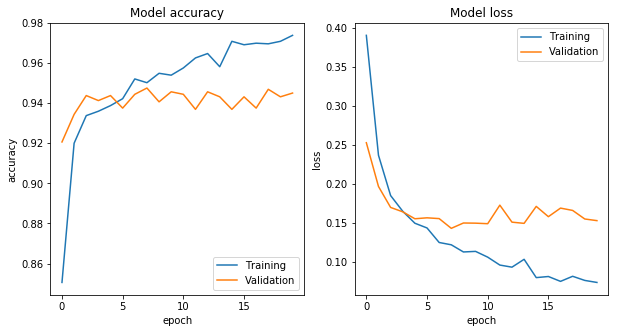

In [0]:
plot_training_history(history3)
mpl.rcParams['figure.figsize'] = (4,5)

While for the training data the loss keeps decreasing, the test data loss stabilises. At this point the model starts to "overfit": the improvements it makes are specific to the training data, but it no longer captures any _general_ trend in the data. If the overfitted model is applied to new data it will perform worse than a model from previous training epochs. This issue becomes more important the deeper the network, because with more parameters we have more potential for overfitting.

<img align="center" src="https://github.com/seismotologist/seismoDL101/blob/master/code/figs/overfit.png?raw=1" width="600">








### The Full Monty: a deeper ConvNet classifier (model4) 
As a final model we use a much deeper convNet classifier that has been used for the same signal/noise discrimination task by __[Meier et al., 2019, JGR](https://arxiv.org/abs/1901.03467)__. This relatively standard convNet model is too large to train on a laptop, so we will be using the pre-trained model that has been optimised over a data set of ~750k seismograms. While the model is much more complex than our Model 3, it would still be considered a small and rather shallow model in a modern data science context. After all, it _only_ has ~235k free parameters... :) As of today (February 2019) the largest published network has [160 billion parameters](https://spectrum.ieee.org/tech-talk/computing/software/biggest-neural-network-ever-pushes-ai-deep-learning)! While this would most certainly make [John von Neumann](https://en.wikiquote.org/wiki/John_von_Neumann) cringe, such extremely complex models perform demonstrably better at the task they have been trained for than simpler models. 

In [0]:
!wget https://github.com/seismotologist/seismoDL101/raw/master/models/meier_etal_jgr19_b3000.h5 -O meier_etal_jgr19_b3000.h5

--2019-09-03 05:59:21--  https://github.com/seismotologist/seismoDL101/raw/master/models/meier_etal_jgr19_b3000.h5
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/seismotologist/seismoDL101/master/models/meier_etal_jgr19_b3000.h5 [following]
--2019-09-03 05:59:22--  https://raw.githubusercontent.com/seismotologist/seismoDL101/master/models/meier_etal_jgr19_b3000.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2905136 (2.8M) [application/octet-stream]
Saving to: ‘meier_etal_jgr19_b3000.h5’

meier_etal_jgr19_b3 100%[===================>]   2.77M  --.-KB/s    in 0.04s   

2019-09-03 05:59:22 (66.9 MB

In [0]:
# Loading and printing the model of Meier et al., 2019, JGR
fullModelName  = 'meier_etal_jgr19_b3000.h5'
model4 = keras.models.load_model(fullModelName)
print(model4)
print(model4.summary())
#print(dir(model))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 400, 32)           1568      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 64)           32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 64)           256       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 64)          

Note how the numbers of parameters change with increasing depth of the network.  

## 3 Performance Comparison Between Models
Now that we have trained all models we can apply them to the test data set, which we haven't touched so far. This will allow us to assess the _out of sample model peformance_, i.e. the performance on data that the models have not seen during training. This should give us a good idea for what performance we can expect the model to have on future data. When we compiled the models we told them to keep track of the classification accuracy (`metrics=['accuracy']`). The models will therefore return the accuracies for us to analyse.

In [0]:
score2 = model2.evaluate(F_test, Y_test)
score3 = model3.evaluate(W_test, Y_test_1hot)
score4 = model4.evaluate(W_test, Y_test_1hot)

# Model 1 is different because it is from scikit-learn, not keras
m1_acc = model1.score(F_test,Y_test)

2000/2000 [==============================] - 1s 343us/step


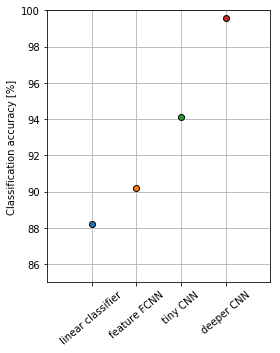

In [0]:
# Plot Accuracies
fig = plt.figure()
plt.plot(0,100*m1_acc   ,marker='o',markeredgecolor='k')
plt.plot(1,100*score2[1],marker='o',markeredgecolor='k')
plt.plot(2,100*score3[1],marker='o',markeredgecolor='k')
plt.plot(3,100*score4[1],marker='o',markeredgecolor='k')

plt.ylabel("Classification accuracy [%]")
plt.grid(True)
plt.ylim((85, 100))
plt.xlim((-1, 4))

plt.xticks([0,1,2,3], 
           ('linear classifier', 'feature FCNN', 'tiny CNN', 'deeper CNN'),
           rotation=40)
plt.show();


The trend is clear: the more complex, deeper models that work with raw data perform better than the simpler, feature-based ones. The deeper convNet classifier reaches very high accuracy which may be close to the error rate in the data set itself. This is one of the reasons why deep learning models are such a game changer: if we have enough data we can now do classification and regression tasks _much_ better than we could with standard linear methods. In fact, for many tasks we can approach the performance of human experts, or even exceed it.  

##### Performance Analysis With Precision & Recall
For each input seismogram the neural network classifiers return a probability estimate that the seismogram belongs to the quake classe, _p(quake)_. In pracice, we need to make a binary decision, it's either a quake or it is not. For this we define a _triggering threshold_: when the estimated _p(quake)_ exceeds the triggering threshold (e.g. 0.5) we classify the signal as a quake signal. We can then evalute the model by how many correct classifications it makes. If we take quakes to be _'positive'_ events we can define 
- true positives: 'TP', quake signal classified as quake
- true negative:  'TN', noise signal classified as noise
- false positive: 'FP', noise signal classified as quake
- false negative: 'FN', quake signal classified as noise

We can then count how often each of these four cases occur, and compute
- Precision: TP/(TP+FP)
- Recall:    TP/(TP+FN)

Precision says: 'Of all the quake detections you've made, how many were correct?'. Recall says: 'Of all the quakes you should have detected, how many _did_ you detect?'. The two quantitites trade off with each other: if we choose a low triggering threshold we have no missed (FN) cases, but many FP cases. If we increase the threshold we reduce the number of FP cases, but now we start to miss some detections. Depending on the context, either precision or recall may be more important, so we can use the triggering threshold as a tuning parameter.

In [0]:
def get_precall(y_prob,y_test,prPrimeVect):
        
    y_test = y_test.flatten()
    
    pr = []
    re = []
    ac = []

    for p_min in prPrimeVect:
        lgc_predQ = (y_prob>=p_min)
        lgc_testQ = (y_test==1)
        
        ntp       = np.sum( lgc_predQ &  lgc_testQ)
        ntn       = np.sum(~lgc_predQ & ~lgc_testQ)
        nfp       = np.sum( lgc_predQ & ~lgc_testQ)
        nfn       = np.sum(~lgc_predQ &  lgc_testQ)
        precision = np.true_divide(ntp,(ntp+nfp))
        recall    = np.true_divide(ntp,(ntp+nfn))
        accuracy  = np.true_divide((ntp+ntn),(ntp+ntn+nfp+nfn))
        pr.append(precision)
        re.append(recall)
        ac.append(accuracy)
        
    return pr, re, ac

In [0]:
Y_prob2 = model2.predict_proba(F_test, verbose=1)
Y_prob3 = model3.predict_proba(W_test, verbose=1)
Y_prob4 = model4.predict_proba(W_test, verbose=1)
#print(Y_prob2)

prPrime = np.arange(0, 1.0, 0.1)
npr     = prPrime.shape[0]
pr2, re2, ac2  = get_precall(Y_prob2,Y_test,prPrime)
pr3, re3, ac3  = get_precall(Y_prob3[:,1],Y_test,prPrime)
pr4, re4, ac4  = get_precall(Y_prob4[:,1],Y_test,prPrime)

2000/2000 [==============================] - 1s 307us/step


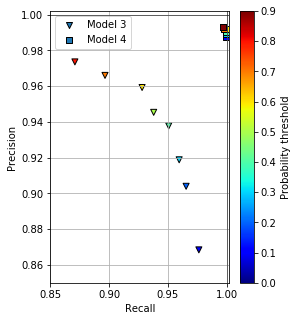

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)

p3 = plt.scatter(re3,pr3, c=prPrime, cmap='jet', marker='v', edgecolor='k')
p4 = plt.scatter(re4,pr4, c=prPrime, cmap='jet', marker='s', edgecolor='k')
#ax.annotate(str(ntl), xy=(re1[-1]-.005, pr1[-1]-.005))                
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.plot([0,2],[1,1],c='k',linewidth=0.5)
plt.plot([1,1],[0,2],c='k',linewidth=0.5)
plt.xlim((0.85, 1.002))
plt.ylim((0.85, 1.002))
plt.legend( (p3,p4), ('Model 3', 'Model 4'))
cbar = plt.colorbar();
cbar.set_label('Probability threshold');

The above figure nicely shows the trade-off between precision and recall, or between the number of false positive and false negative cases. We can use this curve to set our triggering threshold, depending on if we care more about the former or the latter.

Maybe more importantly, it also shows the extent to which the deeper model 4 outpeforms the shallower model 3. This suggests the general conclusion that __the more data you have, the deeper a model you can afford, and the better your model performs__.

## 4 Just how much data do you need...?
In classical data modelling there is the paradigm that you need more data points than free parameters, ideally at least an order of magnitude more. However, for deep learning models this does not seem to hold. A lot of successful deep learning models actually have orders of magnitude more parameters than data points. Yet, these models demonstrably perform much better than the simpler models on independent testing data sets. 

But there must be a lower limit below which we cannot train a deep model, right? How much data _do_ we need to successfully train a model? The answer is that there is no simple threshold above which training works, and below which it fails. Instead, the model performance improves continuously the more data is being used. While for shallower models the performance saturates, the performance of deeper models keeps improving as we add more data: 
<img align="center" src="https://github.com/seismotologist/seismoDL101/blob/master/code/figs/datasize_vs_performance.png?raw=1" width="400">

The figure above is from __[this excellent blog on deep learning](https://lilianweng.github.io/lil-log/2017/06/21/an-overview-of-deep-learning.html)__  by Lilian Weng.


##### Train two convNets with increasing amounts of data
To quantify these performance tendencies for our particular signal classification problem, we re-train the convNet models (models 3 & 4) with variable amounts of data. We start with using only 100 training records and gradually increase the training set size, until all 8000 training records are used. To measure the model performance we always use the same 2,000 test data records as before.   

In [0]:
nmaxvect = np.logspace(2,4,5,dtype=int)

maxepoch = 30   # Depending on your hardware, you may want to lower this

acc3 = []
acc4 = []

nparams3 = model3.count_params()
nparams4 = model4.count_params()

print('Comparing performance of\n',
      ' . tiny   convNet (model 3), '+str(nparams3)+' params)\n',
      ' . deeper convNet (model 4), '+str(nparams4)+' params)\n')
      
# for nmax in nmaxvect:
#     print('\nN = '+str(nmax))
#     Wi = W_train[0:nmax,:,:]
#     Yi = Y_train_1hot[0:nmax,:]
#     print('Input data shape: ',Wi.shape)
    
#     # Reset weights of all models
#     K.get_session().close()
#     K.set_session(tf.Session())
#     K.get_session().run(tf.global_variables_initializer())

#     # Tiny convNet model
#     history3 = model3.fit(Wi, Yi,
#                       validation_split=0.2, batch_size=32, 
#                       epochs=maxepoch, verbose=0)

#     # Deeper convNet model
#     history4 = model4.fit(Wi, Yi,
#                       validation_split=0.2, batch_size=32, 
#                       epochs=maxepoch, verbose=0)

#     # Evaluate all models on the same 2,000 test records
#     sc3 = model3.evaluate(W_test, Y_test_1hot)
#     sc4 = model4.evaluate(W_test, Y_test_1hot)
#     acc3.append(sc3[1])
#     acc4.append(sc4[1])
#     print('Accuracy of model 3: ',acc3)
#     print('Accuracy of model 4: ',acc4)

Comparing performance of
  . tiny   convNet (model 3), 6574 params)
  . deeper convNet (model 4), 235298 params)


N = 100
Input data shape:  (100, 400, 3)


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5b37b61898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5b37b61208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at

2000/2000 [==============================] - 0s 156us/step
Accuracy of model 3:  [0.826]
Accuracy of model 4:  [0.8695]

N = 316
Input data shape:  (316, 400, 3)


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5aea0300b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5b37b61898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at

2000/2000 [==============================] - 0s 162us/step
Accuracy of model 3:  [0.826, 0.842]
Accuracy of model 4:  [0.8695, 0.833]

N = 1000
Input data shape:  (1000, 400, 3)


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5b39d7e5f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5b39d7e7b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at

2000/2000 [==============================] - 0s 172us/step
Accuracy of model 3:  [0.826, 0.842, 0.8825]
Accuracy of model 4:  [0.8695, 0.833, 0.9615]

N = 3162
Input data shape:  (3162, 400, 3)


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5aea0182b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5aea018400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at

2000/2000 [==============================] - 0s 180us/step
Accuracy of model 3:  [0.826, 0.842, 0.8825, 0.9075]
Accuracy of model 4:  [0.8695, 0.833, 0.9615, 0.9645]

N = 10000
Input data shape:  (8000, 400, 3)


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5aea020f60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f5aea020b70>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at

2000/2000 [==============================] - 0s 158us/step
Accuracy of model 3:  [0.826, 0.842, 0.8825, 0.9075, 0.9435]
Accuracy of model 4:  [0.8695, 0.833, 0.9615, 0.9645, 0.971]


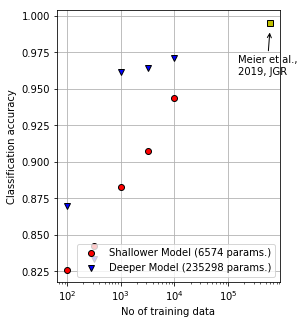

In [0]:
fig = plt.figure()
acc3 = [0.826, 0.842, 0.8825, 0.9075, 0.9435]
acc4 = [0.8695, 0.833, 0.9615, 0.9645, 0.971]
p3 = plt.plot(nmaxvect,acc3,'o',color='r',markeredgecolor='k')
p4 = plt.plot(nmaxvect,acc4,'v',color='b',markeredgecolor='k')
plt.plot(6e5,score4[1]     ,'s',color='y',markeredgecolor='k')
plt.xlabel("No of training data")
plt.ylabel("Classification accuracy")
#plt.title("No of parameters: "+str(nparams))
plt.grid(True)
plt.xscale('log')
plt.legend([p3[0],p4[0]],['Shallower Model ('+str(nparams3)+' params.)', 
                          'Deeper Model ('+str(nparams4)+' params.)'], 
                          loc='lower right')

plt.annotate('Meier et al.,\n2019, JGR',
            xy=(6e5, .99), xytext=(1.5e5, .96),
            arrowprops=dict(arrowstyle="->"))
plt.show();

The model performances continuously improve as we use more training data. The model of __[Meier et al., 2019, JGR](https://arxiv.org/abs/1901.03467)__, which was trained on ~750k records, reaches a classification accuracy of ~99.5%. It is both impressive and, actually, puzzling that even with just a few hundred training records these complex models reach relatively high classification accuracies. Their accuracies are significantly higher than those achieved by e.g. the linear Model 1 (not shown here). Why such complex, underconstrained models work as well as they do with the limited data we typically have is an active data science research question.  
 

##### Training really deep models
For the sake of simplicity, we have restricted ourselves to models we can train on a laptop. If we want to train really deep models, there is nothing different in principle to how we trained Model 3. The main pratical difference is that we need _more data_ and _more processing power_, preferentially Graphics Processing Units (GPUs), which excel at parallelising the matrix multiplications that lie at the heart of deep learning model optimisations. The large amounts of data cannot be loaded into memory all at once; they need to be loaded in batches on the fly. For this reason, and to fully exploit the speed GPUs can provide, you need to define (and train on) _data generators_ that feed data batches to the GPUs in real-time, to keep them maximally busy at all times. Here's a __[tutorial](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)__ for how to do this with keras.

## 5 Take home messages
So, in summary, we've seen that 
- Deeper models that work directly on raw input data can outperform simpler models, by impressive margins
- This can be the case even if the training data set is small compared to the number of trainable model parameters 
- But in deep learning, data is king, and adding more data almost always boosts performance

As a design strategy I would often experiment with deeper models until I reach a performance limit. After that, I try to simplify the models again, e.g. by using fewer channels or layers. If I can find a simpler model that has the same performance, I'll opt for the simpler one. At least on this one point J. v. Neumann might have agreed! :)

I hope you've enjoyed the tutorial. For questions, comments and suggestions, please email me anytime, olé!
(\\_/)

<img align="right" src="https://github.com/seismotologist/seismoDL101/blob/master/code/figs/Rubik_svg.png?raw=1" width="40">
